# Usiminas: Residência em Ciência de Dados

**Disciplina:** Probabilidade e Análise de Dados com Python

**Professores:** Flávio Figueiredo e Pedro Melo

**Aula 9:** Estudo de caso ENEM

# CADERNO DE EXERCÍCIOS - AULA 09

Utilizando as técnicas aprendidas até agora, analise os microdados do ENEM 2020 para responder às perguntas a seguir. Caso seja possível, gere visualizações apropriadas para cada uma delas.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [15]:
# Carregando o dataframe
# Encoding cp860 é o encoding para português. utf-8 não lê estes dados.
import ssl
import urllib.request
import io

ssl_ctx = ssl.create_default_context()
ssl_ctx.check_hostname = False
ssl_ctx.verify_mode = ssl.CERT_NONE

url = 'http://dcc.ufmg.br/~flaviovdf/MICRODADOS_ENEM_2020_FILTRADOS.csv'

with urllib.request.urlopen(url, context=ssl_ctx) as response:
    csv_data = response.read().decode('cp860')

    enem = pd.read_csv(io.StringIO(csv_data))

## 1. Quais os 5 estados brasileiros com maior taxa de ausência (geral) no ENEM 2020?


5 estados com maior taxa de ausência no ENEM 2020:
 SG_UF_ESC
AM    0.634894
RO    0.573084
TO    0.519097
CE    0.500433
GO    0.498504
Name: TP_PRESENCA_CN, dtype: float64


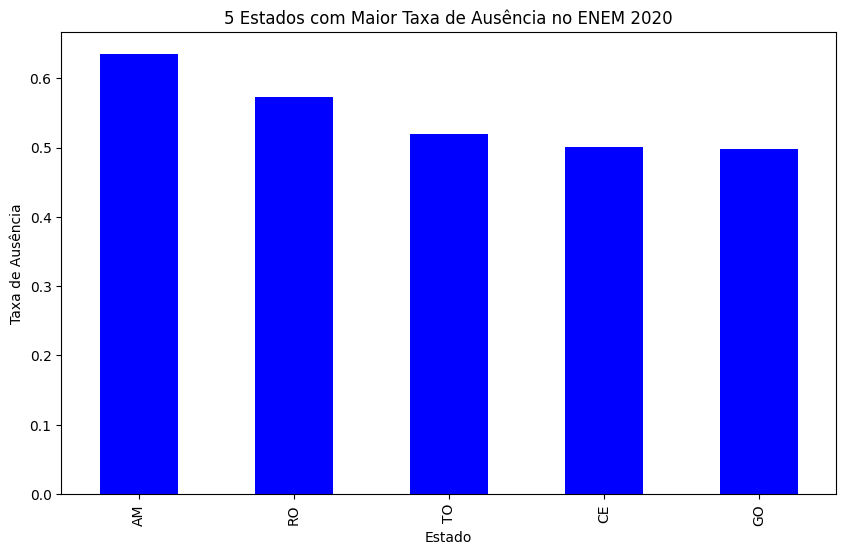

In [16]:
ausencia_por_estado = enem.groupby('SG_UF_ESC')['TP_PRESENCA_CN'].apply(lambda x: (x == 0).mean())

top5_ausentes = ausencia_por_estado.sort_values(ascending=False).head(5)
print("5 estados com maior taxa de ausência no ENEM 2020:\n", top5_ausentes)

plt.figure(figsize=(10, 6))
top5_ausentes.plot(kind='bar', color='blue')
plt.title('5 Estados com Maior Taxa de Ausência no ENEM 2020')
plt.xlabel('Estado')
plt.ylabel('Taxa de Ausência')
plt.show()


## 2. Como a probabilidade de um(a) candidato(a) obter nota superior a 600 na redação varia com o tempo desde que ele(a) concluiu o segundo grau? Esta tendência é a mesma observada em Ciências da natureza?

**Ovservação:** O valor da coluna TP_ANO_CONCLUIU já indica o tempo desde a conclusão até prova. Entretanto, o valor 0 não necessariamente indica que o estudante concluiu em 2020! Elimine este valor para análises mais precisas.

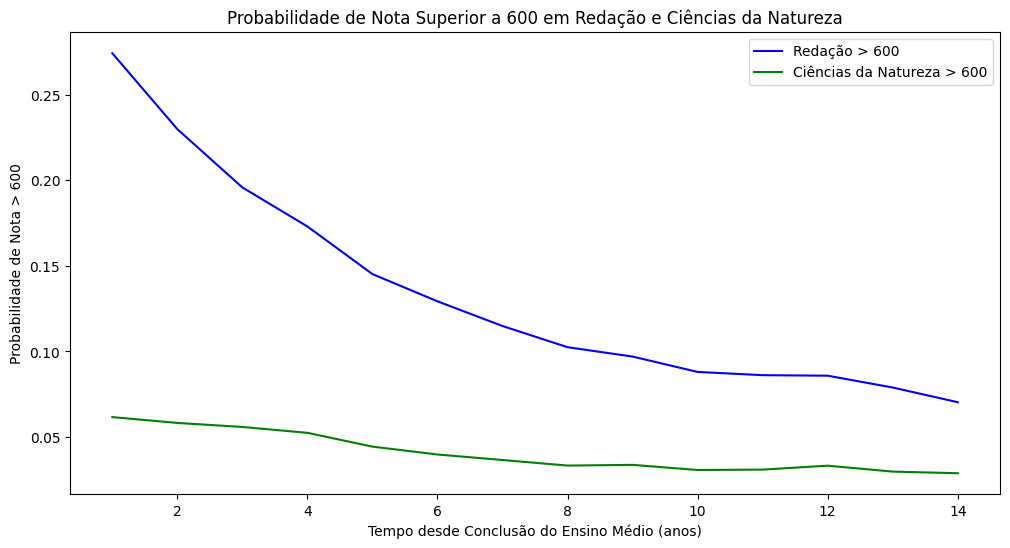

In [17]:
# Filtrar candidatos com 'TP_ANO_CONCLUIU' diferente de 0
enem_filtrado = enem[enem['TP_ANO_CONCLUIU'] != 0].copy()  # Usar .copy() para evitar o aviso

# Criar as colunas indicadoras para notas superiores a 600 usando .loc
enem_filtrado.loc[:, 'REDACAO_600'] = enem_filtrado['NU_NOTA_REDACAO'] > 600
enem_filtrado.loc[:, 'CIENCIAS_600'] = enem_filtrado['NU_NOTA_CN'] > 600

# Calcular a proporção de notas acima de 600 por tempo desde conclusão
prob_redacao = enem_filtrado.groupby('TP_ANO_CONCLUIU')['REDACAO_600'].mean()
prob_ciencias = enem_filtrado.groupby('TP_ANO_CONCLUIU')['CIENCIAS_600'].mean()

# Visualizar a tendência
plt.figure(figsize=(12, 6))
plt.plot(prob_redacao, label='Redação > 600', color='blue')
plt.plot(prob_ciencias, label='Ciências da Natureza > 600', color='green')
plt.title('Probabilidade de Nota Superior a 600 em Redação e Ciências da Natureza')
plt.xlabel('Tempo desde Conclusão do Ensino Médio (anos)')
plt.ylabel('Probabilidade de Nota > 600')
plt.legend()
plt.show()


## 3. Como fatores como renda (Q006), número de pessoas que moram na mesma residência que o candidato (Q005), e a faixa etária (TP_FAIXA_ETARIA) do participante influenciam em sua nota em Matemática?

**Sugestões:** Para análises mais precisas, elimine as notas 0 e os candidatos que faltaram nas provas analisadas (ex:TP_PRESENCA_MT=0). Como as notas são uma escala contínua, você pode optar, se preferir, por torná-la discreta, criando classes que englobem faixas de notas (ex: 200<NU_NOTA_MT<400).

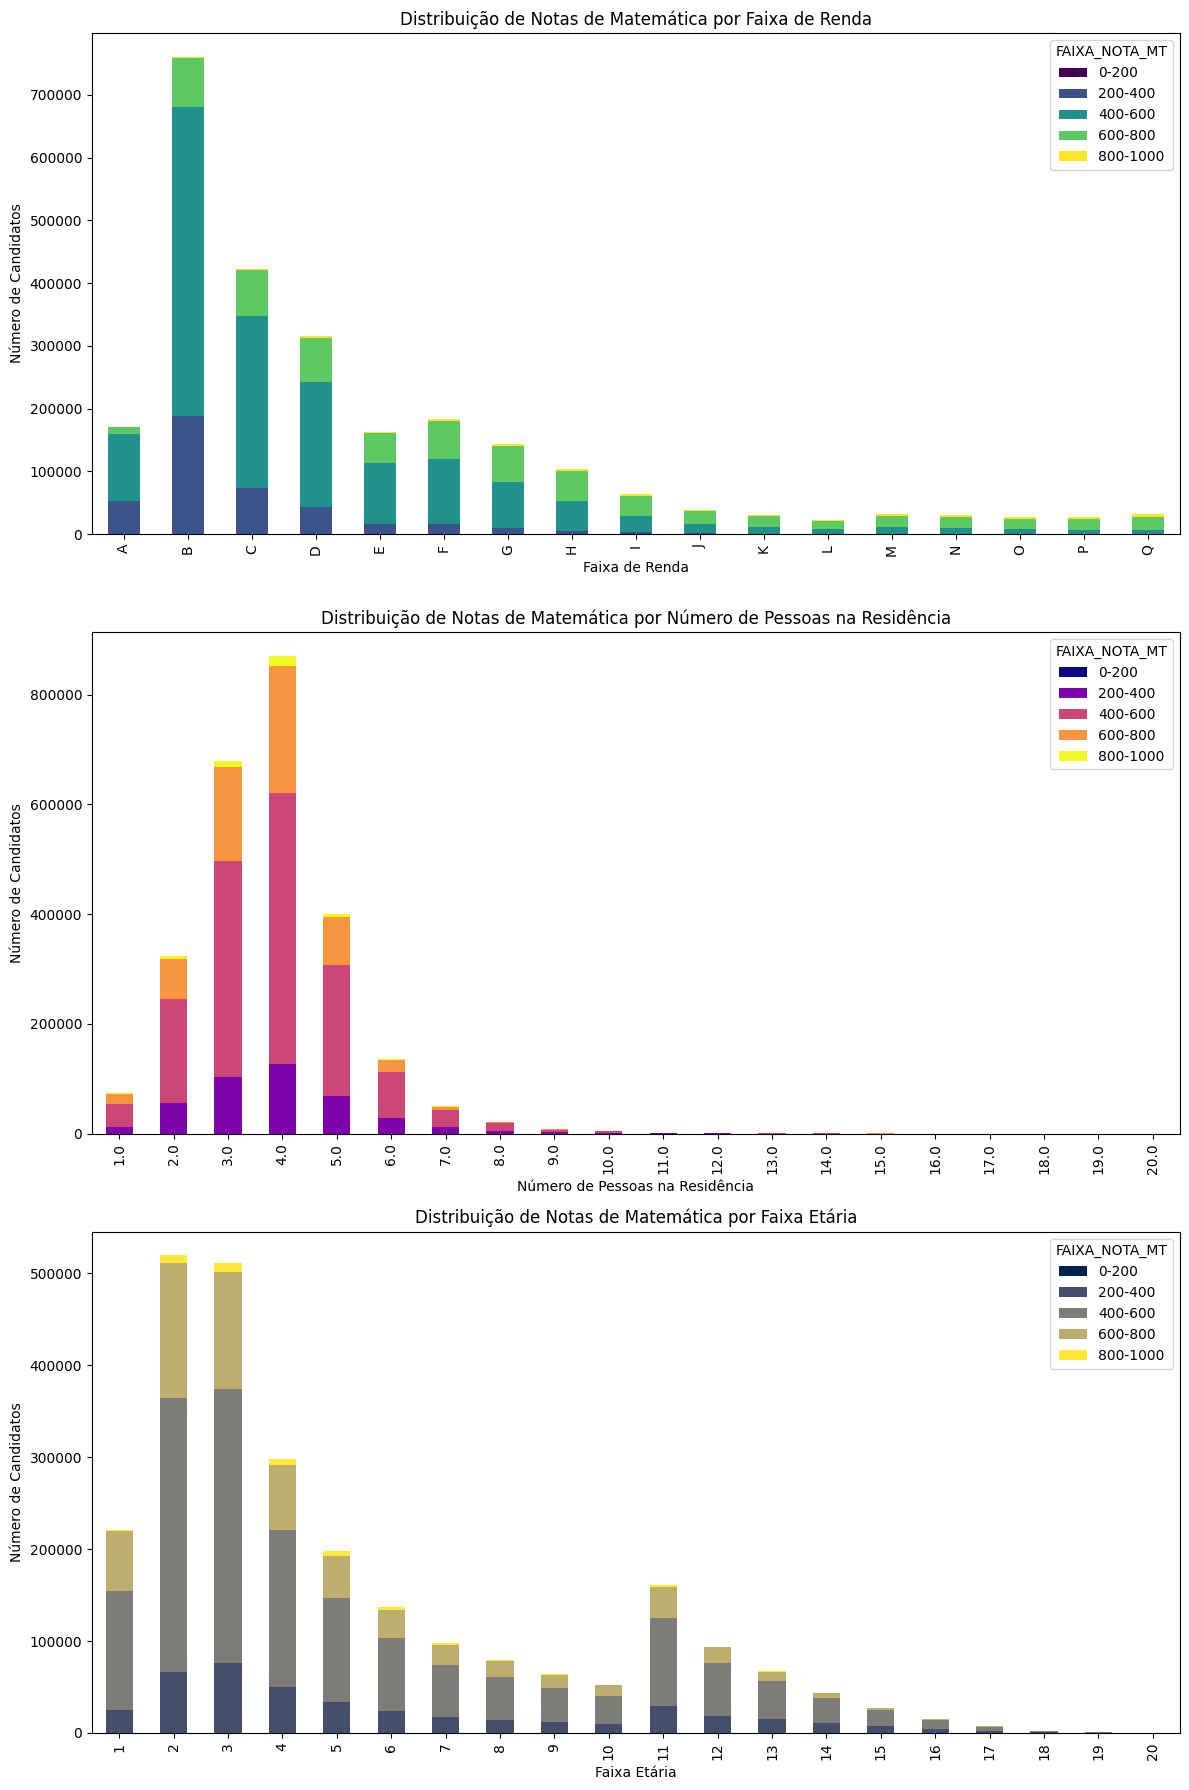

In [18]:
# Filtrar candidatos que fizeram a prova de Matemática e obtiveram nota acima de 0
enem_math = enem[(enem['TP_PRESENCA_MT'] == 1) & (enem['NU_NOTA_MT'] > 0)].copy()

# Criar faixas de notas de Matemática (exemplo: 200-400, 400-600, 600-800, 800-1000)
bins = [0, 200, 400, 600, 800, 1000]
labels = ['0-200', '200-400', '400-600', '600-800', '800-1000']
enem_math['FAIXA_NOTA_MT'] = pd.cut(enem_math['NU_NOTA_MT'], bins=bins, labels=labels, right=False)

# Analisar a influência de cada fator:
# Renda (Q006) vs Faixa de Notas em Matemática
renda_vs_nota = enem_math.groupby(['Q006', 'FAIXA_NOTA_MT'], observed=False).size().unstack().fillna(0)

# Número de pessoas na residência (Q005) vs Faixa de Notas em Matemática
residencia_vs_nota = enem_math.groupby(['Q005', 'FAIXA_NOTA_MT'], observed=False).size().unstack().fillna(0)

# Faixa etária (TP_FAIXA_ETARIA) vs Faixa de Notas em Matemática
idade_vs_nota = enem_math.groupby(['TP_FAIXA_ETARIA', 'FAIXA_NOTA_MT'], observed=False).size().unstack().fillna(0)

# Visualizar os resultados
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Renda vs Notas
renda_vs_nota.plot(kind='bar', stacked=True, ax=axs[0], colormap="viridis")
axs[0].set_title('Distribuição de Notas de Matemática por Faixa de Renda')
axs[0].set_xlabel('Faixa de Renda')
axs[0].set_ylabel('Número de Candidatos')

# Pessoas na residência vs Notas
residencia_vs_nota.plot(kind='bar', stacked=True, ax=axs[1], colormap="plasma")
axs[1].set_title('Distribuição de Notas de Matemática por Número de Pessoas na Residência')
axs[1].set_xlabel('Número de Pessoas na Residência')
axs[1].set_ylabel('Número de Candidatos')

# Faixa etária vs Notas
idade_vs_nota.plot(kind='bar', stacked=True, ax=axs[2], colormap="cividis")
axs[2].set_title('Distribuição de Notas de Matemática por Faixa Etária')
axs[2].set_xlabel('Faixa Etária')
axs[2].set_ylabel('Número de Candidatos')

plt.tight_layout()
plt.show()
